# Optimizing autoencoder network and training parameters with Optuna

In [19]:
# import this package 
from pytorch_pae import AE, utils

In [2]:
import optuna
from optuna.trial import TrialState
import logging

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [43]:
# import pytorch
import torch
from torchsummary import summary
print(torch.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.8.0
cuda:0


In [5]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

study_folder  = '/global/cscratch1/sd/vboehm/OptunaStudies/'
study_name    = "conv_AE_optimization"  # Unique identifier of the study.
study_name    = os.path.join(study_folder, study_name)
storage_name  = "sqlite:///{}.db".format(study_name)
EPOCHS        = 20
NUM_HOURS     = 1
N_TRIALS      = 10
SEED          = 314159

In [58]:
def objective(trial):
    
    
    ## data parameters
    dataset       = 'MNIST'
    loc           = '/global/cscratch1/sd/vboehm/Datasets'

    # padding values in each conv layer
    paddings     = [2]
    # stride values in each conv layer
    # whether tp apply a layer normalization after conv layer
    layer_norm   = [True]
    # whether to train elemntwise affine parameters for normalization layer 
    affine       = False
    # whether to Lipschitz regularize by bounding the spectral norm 
    spec_norm    = True
    # activation function after each layer
    activations  = ['ReLU']
    # whether to add a bias in each layer or not
    bias         = [True]

    # data dimensionality
    dim          = '2D'
    # latent space dimensionality
    latent_dim   = 8
    # number of channels in data
    input_c      = 1 
    # data dimensioality along one axis (only square data supported in 2D)
    input_dim    = 28
    # type of encoder and decoder network (either 'fc' or 'conv')
    encoder_type = 'conv'
    decoder_type = 'conv'

    # if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
    final_sigmoid = True

    ## Training parameters
    nepochs       = EPOCHS
    batchsize     = 64
    initial_lr    = 1e-2

    optimizer        = 'Adam'
    criterion        = 'MSELoss'

    scheduler        = 'ExponentialLR'
    scheduler_params = {'gamma':0.95}
    
    n_layers   = trial.suggest_int('n_layers',1,3)
    latent_dim = trial.suggest_int('latent_dim',2,10)
    
    activations = activations*n_layers
    bias        = bias*n_layers
    layer_norm  = layer_norm*n_layers
    
    
    out_channels = []
    kernel_sizes = []
    strides      = []
    scale_facs   = []
    dropout_rate = []
    
    current_size = input_dim 
    for ii in range(n_layers):
        print(current_size)
        out_channels.append(trial.suggest_int('out_channel_%d'%ii,4,32))
        kernel_sizes.append(trial.suggest_int('kernel_size_%d'%ii,2,max(4,int(current_size)//2)))
        strides.append(trial.suggest_int('stride_%d'%ii,1,kernel_sizes[ii]))
        paddings.append(trial.suggest_int('padding_%d'%ii,0,kernel_sizes[ii]))
        current_size = utils.output_shape(current_size,strides[ii],paddings[ii],kernel_sizes[ii],dilation=1)
        if current_size>3*latent_dim:
            scale_facs.append(trial.suggest_int('scale_fac_%d'%ii,1,2))
        else:
            scale_facs.append(1)
        current_size = current_size//scale_facs[ii]
        dropout_rate.append(trial.suggest_float('dropout_rate_%d'%ii,1e-3,1,log=True))
        # if current_size<=latent_dim:
        #     n_layers=ii
        #     break
            

    
    general_params      = {'input_c': input_c, 'input_dim': input_dim, 'latent_dim': latent_dim, 'encoder_type': encoder_type, 'decoder_type': decoder_type, 'dim': dim}
    conv_network_params = {'n_layers': n_layers, 'out_channels': out_channels, 'kernel_sizes': kernel_sizes, 'scale_facs': scale_facs, 'paddings': paddings,\
                       'strides': strides,'activations': activations, 'spec_norm': spec_norm, 'dropout_rate':dropout_rate, 'layer_norm': layer_norm,\
                       'affine': affine,'final_sigmoid': final_sigmoid, 'bias':bias}

    training_params     = {'batchsize': batchsize, 'initial_lr': initial_lr, 'optimizer': optimizer, 'criterion': criterion, \
                       'scheduler': scheduler, 'scheduler_params':scheduler_params}
    data_params         = {'dataset':dataset, 'loc': loc}
    
    try:
        AE1                 = AE.Autoencoder(general_params,data_params,conv_network_params, conv_network_params, training_params, device)
    
        if dim =='1D':
            summary(AE1, (input_c,input_dim))
        else:
            summary(AE1, (input_c, input_dim, input_dim))

        train_loss, valid_loss = AE1.train(nepochs)
    except:
        valid_loss = 100
    
    return valid_loss

In [ ]:
time = NUM_HOURS*60*60-600
study = optuna.create_study(direction='minimize',study_name=study_name, storage=storage_name,load_if_exists=True,  sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=N_TRIALS, timeout=time)

[I 2022-01-14 17:47:28,801] Using an existing study with name '/global/cscratch1/sd/vboehm/OptunaStudies/conv_AE_optimization' instead of creating a new one.


Using an existing study with name '/global/cscratch1/sd/vboehm/OptunaStudies/conv_AE_optimization' instead of creating a new one.
28
10
10
10
5
5
5
4
4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 10, 10]             160
         LayerNorm-2           [-1, 16, 10, 10]               0
              ReLU-3           [-1, 16, 10, 10]               0
 AdaptiveMaxPool2d-4           [-1, 16, 10, 10]               0
            Conv2d-5             [-1, 27, 5, 5]           6,939
         LayerNorm-6             [-1, 27, 5, 5]               0
              ReLU-7             [-1, 27, 5, 5]               0
 AdaptiveMaxPool2d-8             [-1, 27, 5, 5]               0
            Conv2d-9             [-1, 11, 4, 4]           1,199
        LayerNorm-10             [-1, 11, 4, 4]               0
             ReLU-11             [-1, 11, 4, 4]               0
AdaptiveMaxPool

[W 2022-01-14 17:51:03,014] Trial 34 failed, because the number of the values 20 did not match the number of the objectives 1.


Trial 34 failed, because the number of the values 20 did not match the number of the objectives 1.
28
3
3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 22, 3, 3]           3,740
         LayerNorm-2             [-1, 22, 3, 3]               0
              ReLU-3             [-1, 22, 3, 3]               0
 AdaptiveMaxPool2d-4             [-1, 22, 3, 3]               0
           Flatten-5                  [-1, 198]               0
            Linear-6                    [-1, 9]           1,791
       ConvEncoder-7                    [-1, 9]               0
           Flatten-8                    [-1, 9]               0
            Linear-9                  [-1, 198]           1,980
          Reshape-10             [-1, 22, 3, 3]               0
             ReLU-11             [-1, 22, 3, 3]               0
         Upsample-12             [-1, 22, 3, 3]              

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


In [9]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             272
         LayerNorm-2           [-1, 16, 13, 13]               0
              ReLU-3           [-1, 16, 13, 13]               0
 AdaptiveMaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 16, 11, 11]           2,320
         LayerNorm-6           [-1, 16, 11, 11]               0
              ReLU-7           [-1, 16, 11, 11]               0
 AdaptiveMaxPool2d-8           [-1, 16, 11, 11]               0
            Conv2d-9           [-1, 16, 10, 10]           1,040
        LayerNorm-10           [-1, 16, 10, 10]               0
             ReLU-11           [-1, 16, 10, 10]               0
AdaptiveMaxPool2d-12           [-1, 16, 10, 10]               0
          Flatten-13                 [-1, 1600]               0
           Linear-14                   

epoch: 0, training loss: 2.9161e-02, validation loss: 1.9793e-02, learning rate: 9.5000e-03
epoch: 1, training loss: 2.0039e-02, validation loss: 1.8395e-02, learning rate: 9.0250e-03
epoch: 2, training loss: 1.8675e-02, validation loss: 1.8536e-02, learning rate: 8.5737e-03
epoch: 3, training loss: 1.7897e-02, validation loss: 1.6641e-02, learning rate: 8.1451e-03
epoch: 4, training loss: 1.7381e-02, validation loss: 1.5399e-02, learning rate: 7.7378e-03
epoch: 5, training loss: 1.6948e-02, validation loss: 1.7302e-02, learning rate: 7.3509e-03
epoch: 6, training loss: 1.6633e-02, validation loss: 1.6740e-02, learning rate: 6.9834e-03
epoch: 7, training loss: 1.6371e-02, validation loss: 1.6865e-02, learning rate: 6.6342e-03
epoch: 8, training loss: 1.6136e-02, validation loss: 1.6601e-02, learning rate: 6.3025e-03
epoch: 9, training loss: 1.5968e-02, validation loss: 1.4886e-02, learning rate: 5.9874e-03


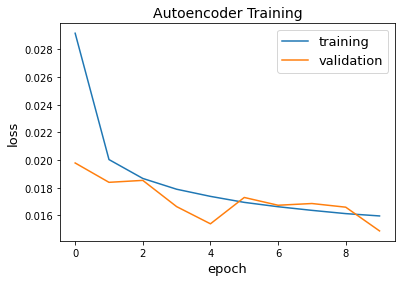

In [11]:
plt.figure()
plt.title('Autoencoder Training',fontsize=14)
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('epoch',fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend(fontsize=13)
plt.show()

## Data reconstructions

In [12]:
from pytorch_pae.data_loader import *

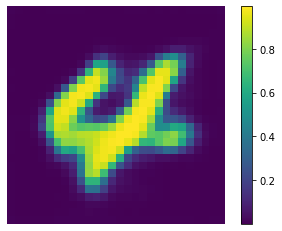

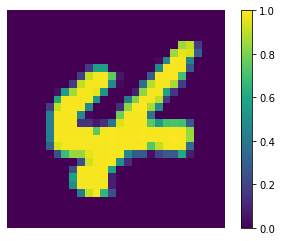

In [13]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],1)

data, _  = next(iter(train_loader))

recon = AE1.forward(data.to(device))

plt.imshow(np.squeeze(recon.cpu().detach().numpy()))
plt.colorbar()
plt.axis('off')
plt.show()

plt.imshow(np.squeeze(data.cpu().detach().numpy()))
plt.colorbar()
plt.axis('off')
plt.show()

del train_loader
del valid_loader

In [14]:
torch.save(AE1, os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'AE'))

## Step 3: Train the density estimator on the encoded data

In [15]:
# import density estimation module
from sinf import GIS

In [16]:
# load auutoencoder
AE1 = torch.load(os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'AE'))

In [17]:
from pytorch_pae.data_loader import *

In [18]:
# encode data

train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],-1, -1)

data, _  = next(iter(train_loader))
data     = data.to(device)

valid_data, _  = next(iter(valid_loader))
valid_data     = valid_data.to(device)

with torch.no_grad():
    encoded_train = AE1.encoder.forward(data)
    encoded_valid = AE1.encoder.forward(valid_data)

In [ ]:
# train density estimator
gis = GIS.GIS(encoded_train, data_validate=encoded_valid)

Fit A: Time: 3.090930419921875 Wasserstein Distance: [2.96004056930542, 2.428279161453247, 1.8504862785339355, 1.7741252183914185, 1.732505440711975, 1.177179217338562, 1.063094973564148, 0.532558262348175]
Fit spline Time: 0.11215382385253907
logp: -34.395938873291016 -33.437618255615234 time: 3.3366329669952393 iteration: 1 best: 1
Fit A: Time: 0.5619705200195313 Wasserstein Distance: [2.644834518432617, 2.2320148944854736, 1.6986836194992065, 1.6008268594741821, 1.5931824445724487, 1.031821370124817, 0.9819366931915283, 0.4978090524673462]
Fit spline Time: 0.06944054412841796
logp: -31.75515365600586 -30.896034240722656 time: 0.6813981533050537 iteration: 2 best: 2
Fit A: Time: 0.5243155517578125 Wasserstein Distance: [2.4006636142730713, 2.0199429988861084, 1.5332263708114624, 1.4542934894561768, 1.4341288805007935, 0.9884594678878784, 0.8618239164352417, 0.43560266494750977]
Fit spline Time: 0.06971881866455078
logp: -29.548067092895508 -28.77475929260254 time: 0.6495316028594971 

In [ ]:
torch.save(gis, os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'GIS'))

## Density Estimation and Outlier Detection

In [ ]:
logps   = gis.evaluate_density(encoded_data)

In [ ]:
_       = plt.histogram(logps)

In [ ]:
ranking = np.argsort(logps)

In [ ]:
fig, ax = plt.subplots(4,4)
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(np.squeeze(data[ranking[ii]].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.show()

## Data Generation

In [ ]:
samples = gis.sample(16)
with torch.no_grad():
    decoded_samples = AE1.decoder.forward(samples)

fig, ax = plt.subplots(4,4)
ax = ax.flatten()
for ii in range(16):
    ax[ii].imshow(no.squeeze(decoded_samples[ii].cpu().detach().numpy()))
    ax[ii].axis('off')
plt.show()